# Breast Cancer Mammography with SVM

# Prepare and Collect Data

In [1]:
import os

data_path = "C:/Users/Hp/MACHINE LEARNING/Lab/ML PROJECT/NEWDATA/Dataset of Mammography with Benign Malignant Breast Masses/INbreast+MIAS+DDSM Dataset"
benign_path = os.path.join(data_path, "Benign Masses")
malignant_path = os.path.join(data_path, "Malignant Masses")

In [2]:
import cv2
from tqdm import tqdm

def load_images(folder_path, label):
    images = []
    labels = []
    for filename in tqdm(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (64, 64))  # Resize the image as needed
        images.append(img)
        labels.append(label)
    return images, labels

In [3]:
benign_images, benign_labels = load_images(benign_path, "Benign Masses")
malignant_images, malignant_labels = load_images(malignant_path, "Malignant Masses")

100%|██████████| 13710/13710 [00:16<00:00, 827.04it/s]


In [4]:
all_images = benign_images + malignant_images
all_labels = benign_labels + malignant_labels

In [5]:
import numpy as np

X = np.array(all_images)
y = np.array(all_labels)

In [6]:
np.unique(y)

array(['Benign Masses', 'Malignant Masses'], dtype='<U16')

In [7]:
import pandas as pd

pd.Series(y).value_counts()

Malignant Masses    13710
Benign Masses       10866
Name: count, dtype: int64

In [8]:
X.shape

(24576, 64, 64, 3)

In [9]:
y.shape

(24576,)

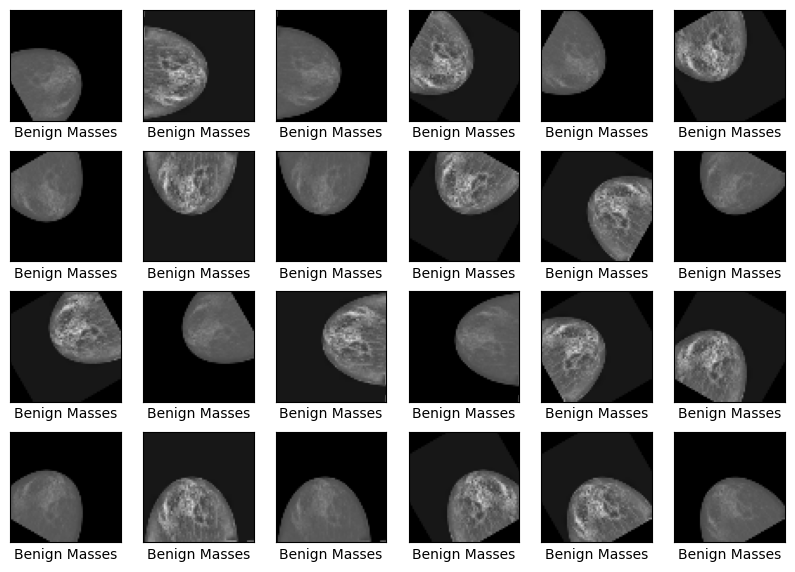

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 6, figsize=(10, 7))
for i, axi in enumerate(ax.flat):
    axi.imshow(X[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=y[i])

In [11]:
X = X.reshape(len(X), -1)
y = y.reshape(len(X), -1)

X.shape, y.shape

((24576, 12288), (24576, 1))

# Split Data

In [12]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=10, 
                                                test_size=.20)

In [13]:
Xtrain.shape, Xtest.shape

((19660, 12288), (4916, 12288))

# Feature Scalling

In [14]:
print(Xtrain.max(), Xtrain.min())
print(Xtest.max(), Xtest.min())

255 0
255 0


In [15]:
Xtrain = Xtrain/255
Xtest = Xtest/255
print(Xtrain.max(), Xtrain.min())
print(Xtest.max(), Xtest.min())

1.0 0.0
1.0 0.0


# Feature Selection

In [16]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

# Train Model

In [17]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.0001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: total: 2h 30min 22s
Wall time: 1h 9min
{'svc__C': 50, 'svc__gamma': 0.005}


In [18]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

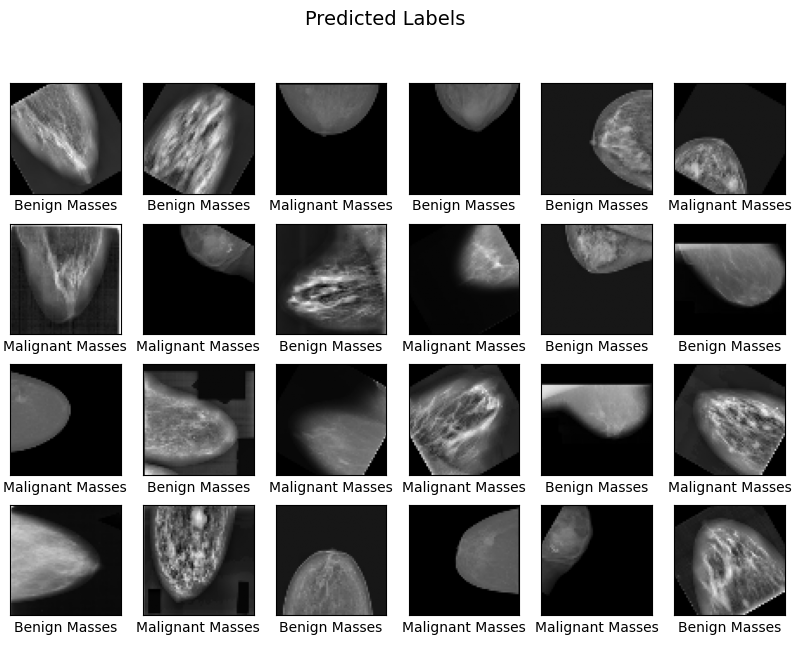

In [19]:
# Reshape the data back to the original shape
Xtest_reshaped = Xtest.reshape((Xtest.shape[0], 64, 64, 3))

# Visualize the predicted images
fig, ax = plt.subplots(4, 6, figsize=(10, 7))

for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest_reshaped[i], cmap='bone')  
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(f'{yfit[i]}', color='red' if yfit[i] != ytest[i] else 'black')

fig.suptitle('Predicted Labels', size=14)
plt.show()

In [20]:
# Periksa pembagian data pelatihan dan pengujian
print(f"Jumlah sampel data pelatihan: {len(ytrain)}")
print(f"Jumlah sampel data pengujian: {len(ytest)}")

Jumlah sampel data pelatihan: 19660
Jumlah sampel data pengujian: 4916


# Evaluation

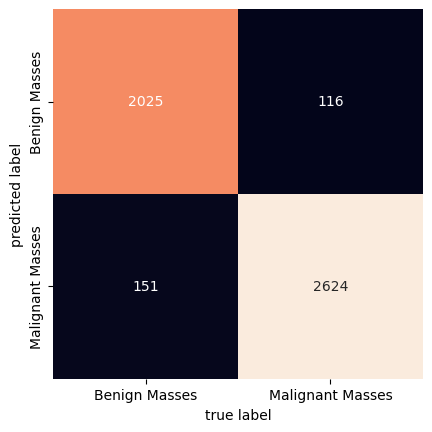

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel('true label')
plt.ylabel('predicted label');

In [22]:
print("Training Score:", model.score(Xtrain.reshape(Xtrain.shape[0], -1), ytrain))
print("Testing Score:", model.score(Xtest.reshape(Xtest.shape[0], -1), ytest))

Training Score: 0.9997456765005086
Testing Score: 0.9456875508543532


In [23]:
from sklearn.metrics import roc_curve, auc

# Compute predicted probabilities for Xtest
y_probs = model.predict_proba(Xtest.reshape(Xtest.shape[0], -1))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y))):
    fpr[i], tpr[i], _ = roc_curve(ytest[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y))):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = %0.2f) for class %s' % (roc_auc[i], np.unique(y)[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

AttributeError: This 'Pipeline' has no attribute 'predict_proba'

# STRATIFIED K-FOLD CROSS VALIDATION

In [24]:
from sklearn.model_selection import StratifiedKFold

# Inisialisasi StratifiedKFold
skf = StratifiedKFold(n_splits=10)

# Lists untuk menyimpan skor akurasi dari setiap lipatan
k_fold_acc = []

# Loop untuk Stratified K-Fold Cross Validation
for train_index, test_index in skf.split(Xtrain, ytrain):
    X_train_fold, X_val_fold = Xtrain[train_index], Xtrain[test_index]
    y_train_fold, y_val_fold = ytrain[train_index], ytrain[test_index]
    
    # Pelatihan model pada lipatan
    model.fit(X_train_fold, y_train_fold)
    
    # Evaluasi model pada lipatan
    acc = model.score(X_val_fold, y_val_fold)
    k_fold_acc.append(acc)

In [25]:
# Hitung rata-rata skor akurasi dari semua lipatan
k_fold_mean = np.mean(k_fold_acc)
k_fold_mean

0.9362665310274669

### TRAIN 2
### Linear

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True)
svc = SVC(kernel='linear', class_weight='balanced')
model = make_pipeline(pca, svc)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.0001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

In [ ]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

In [ ]:
# Reshape the data back to the original shape
Xtest_reshaped = Xtest.reshape((Xtest.shape[0], 64, 64, 3))

# Visualize the predicted images
fig, ax = plt.subplots(4, 6, figsize=(10, 7))

for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest_reshaped[i], cmap='bone')  
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(f'{yfit[i]}', color='red' if yfit[i] != ytest[i] else 'black')

fig.suptitle('Predicted Labels', size=14)
plt.show()

In [ ]:
# Periksa pembagian data pelatihan dan pengujian
print(f"Jumlah sampel data pelatihan: {len(ytrain)}")
print(f"Jumlah sampel data pengujian: {len(ytest)}")

In [ ]:
from sklearn.metrics import classification_report as sklearn_classification_report

def my_classification_report(ytest, yfit, classes):
    report = sklearn_classification_report(ytest, yfit, target_names=classes)
    print(report)

# Plot classification report for SVM
my_classification_report(ytest, model.predict(Xtest), classes=['benign', 'malignant', 'normal'])

In [ ]:
print("Training Score:", model.score(Xtrain.reshape(Xtrain.shape[0], -1), ytrain))
print("Testing Score:", model.score(Xtest.reshape(Xtest.shape[0], -1), ytest))

### TRAIN 3 
### SIGMOID

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True)
svc = SVC(kernel='sigmoid', class_weight='balanced')
model = make_pipeline(pca, svc)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.0001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

In [ ]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

In [ ]:
# Reshape the data back to the original shape
Xtest_reshaped = Xtest.reshape((Xtest.shape[0], 64, 64, 3))

# Visualize the predicted images
fig, ax = plt.subplots(4, 6, figsize=(10, 7))

for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest_reshaped[i], cmap='bone')  
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(f'{yfit[i]}', color='red' if yfit[i] != ytest[i] else 'black')

fig.suptitle('Predicted Labels', size=14)
plt.show()

In [ ]:
# Periksa pembagian data pelatihan dan pengujian
print(f"Jumlah sampel data pelatihan: {len(ytrain)}")
print(f"Jumlah sampel data pengujian: {len(ytest)}")

In [ ]:
from sklearn.metrics import classification_report as sklearn_classification_report

def my_classification_report(ytest, yfit, classes):
    report = sklearn_classification_report(ytest, yfit, target_names=classes)
    print(report)

# Plot classification report for SVM
my_classification_report(ytest, model.predict(Xtest), classes=['benign', 'malignant', 'normal'])

In [ ]:
print("Training Score:", model.score(Xtrain.reshape(Xtrain.shape[0], -1), ytrain))
print("Testing Score:", model.score(Xtest.reshape(Xtest.shape[0], -1), ytest))

### TRAIN 3 
### SIGMOID

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True)
svc = SVC(kernel='sigmoid', class_weight='balanced')
model = make_pipeline(pca, svc)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.0001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

In [ ]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

In [ ]:
# Reshape the data back to the original shape
Xtest_reshaped = Xtest.reshape((Xtest.shape[0], 64, 64, 3))

# Visualize the predicted images
fig, ax = plt.subplots(4, 6, figsize=(10, 7))

for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest_reshaped[i], cmap='bone')  
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(f'{yfit[i]}', color='red' if yfit[i] != ytest[i] else 'black')

fig.suptitle('Predicted Labels', size=14)
plt.show()

In [ ]:
# Periksa pembagian data pelatihan dan pengujian
print(f"Jumlah sampel data pelatihan: {len(ytrain)}")
print(f"Jumlah sampel data pengujian: {len(ytest)}")

In [ ]:
from sklearn.metrics import classification_report as sklearn_classification_report

def my_classification_report(ytest, yfit, classes):
    report = sklearn_classification_report(ytest, yfit, target_names=classes)
    print(report)

# Plot classification report for SVM
my_classification_report(ytest, model.predict(Xtest), classes=['benign', 'malignant', 'normal'])

In [ ]:
print("Training Score:", model.score(Xtrain.reshape(Xtrain.shape[0], -1), ytrain))
print("Testing Score:", model.score(Xtest.reshape(Xtest.shape[0], -1), ytest))

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import warnings

# Membuat model dengan PCA dan SVC
def create_pipeline(kernel='rbf'):
    pca = RandomizedPCA(n_components=150, whiten=True)
    svc = SVC(kernel=kernel, class_weight='balanced')
    model = make_pipeline(pca, svc)
    return model

# Mengatur parameter grid untuk setiap kernel
param_grids = {
    'rbf': {'svc__C': [1, 5, 10, 50],
            'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]},
    'sigmoid': {'svc__C': [1, 5, 10, 50],
                'svc__gamma': [0.0001, 0.0005, 0.001, 0.005],
                'svc__coef0': [0.0, 0.1, 0.5, 1.0]},
    'linear': {'svc__C': [1, 5, 10, 50]}
}

# Membuat dan menjalankan GridSearchCV untuk setiap kernel
results = {}
for kernel, param_grid in param_grids.items():
    model = create_pipeline(kernel)
    grid = GridSearchCV(model, param_grid)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        grid.fit(Xtrain, ytrain)
    results[kernel] = grid

# Menampilkan hasil terbaik untuk setiap kernel
for kernel, grid in results.items():
    print(f"Best parameters for {kernel} kernel: {grid.best_params_}")


In [ ]:
#r
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification

# Membuat dataset sintetis
X, y = make_classification(n_samples=100, n_features=2, n_classes=2, n_clusters_per_class=1, 
                            n_informative=2, n_redundant=0, n_repeated=0, random_state=42)

# Membuat model SVM
svm = SVC(kernel='linear')
svm.fit(X, y)

# Membuat fungsi untuk visualisasi hyperplane
def plot_hyperplane(X, y, clf):
    plt.figure(figsize=(8, 6))

    # Mengurangi dimensi data ke 2
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Plot data point
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.Paired, s=30)

    # Plot hyperplane
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Membuat grid untuk menggambar hyperplane
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])

    # Visualisasi hyperplane dan margin
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])

    # Menandai support vectors
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Support Vector Machine Hyperplane Visualization')
    plt.show()

# Memvisualisasikan hyperplane
plot_hyperplane(X, y, svm)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Membuat dataset sintetis
X, y = make_classification(n_samples=100, n_features=3, n_classes=2, n_clusters_per_class=1, 
                            n_informative=3, n_redundant=0, n_repeated=0, random_state=42)

# Membuat model SVM
svm = SVC(kernel='linear')
svm.fit(X, y)

# Membuat fungsi untuk visualisasi hyperplane dalam 3 dimensi
def plot_hyperplane_3d(X, y, clf):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Mengurangi dimensi data ke 3
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)

    # Plot data point
    ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap=plt.cm.Paired, s=30)

    # Plot hyperplane
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    z = (-clf.intercept_[0] - clf.coef_[0][0] * xx - clf.coef_[0][1] * yy) / clf.coef_[0][2]
    ax.plot_surface(xx, yy, z, color='gray', alpha=0.5)

    # Menandai support vectors
    support_vectors = pca.transform(clf.support_vectors_)
    ax.scatter(support_vectors[:, 0], support_vectors[:, 1], support_vectors[:, 2],
               s=100, linewidth=1, facecolors='none', edgecolors='k')

    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title('Support Vector Machine Hyperplane Visualization in 3D')
    plt.show()

# Memvisualisasikan hyperplane dalam 3 dimensi
plot_hyperplane_3d(X, y, svm)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Membuat dataset sintetis
X, y = make_classification(n_samples=100, n_features=3, n_classes=3, n_clusters_per_class=1, 
                            n_informative=3, n_redundant=0, n_repeated=0, random_state=42)

# Membuat model SVM dengan kernel poly
svm_poly = SVC(kernel='poly', degree=3, coef0=1)
svm_poly.fit(X, y)

# Membuat model SVM dengan kernel rbf
svm_rbf = SVC(kernel='rbf', gamma='auto')
svm_rbf.fit(X, y)

# Membuat model SVM dengan kernel sigmoid
svm_sigmoid = SVC(kernel='sigmoid', coef0=1)
svm_sigmoid.fit(X, y)

# Membuat fungsi untuk visualisasi batas keputusan dalam 3 dimensi
def plot_decision_boundary_3d(X, y, clf, title):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Mengurangi dimensi data ke 3
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)

    # Plot data point
    ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap=plt.cm.Paired, s=30)

    # Plot batas keputusan
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    if clf.kernel == 'poly':
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])
    elif clf.kernel == 'rbf':
        X_mesh = np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())]
        Z = clf.predict(X_mesh)
    elif clf.kernel == 'sigmoid':
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])
    Z = Z.reshape(xx.shape)
    ax.contour3D(xx, yy, Z, 50, cmap='binary', alpha=0.5)

    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title(title)
    plt.show()

# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel poly
plot_decision_boundary_3d(X, y, svm_poly, 'Decision Boundary Visualization in 3D (Poly Kernel)')

# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel rbf
plot_decision_boundary_3d(X, y, svm_rbf, 'Decision Boundary Visualization in 3D (RBF Kernel)')

# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel sigmoid
plot_decision_boundary_3d(X, y, svm_sigmoid, 'Decision Boundary Visualization in 3D (Sigmoid Kernel)')


### TRAIN 4 POLY

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True)
svc = SVC(kernel='poly', class_weight='balanced')
model = make_pipeline(pca, svc)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.0001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

In [ ]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

In [ ]:
# Reshape the data back to the original shape
Xtest_reshaped = Xtest.reshape((Xtest.shape[0], 64, 64, 3))

# Visualize the predicted images
fig, ax = plt.subplots(4, 6, figsize=(10, 7))

for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest_reshaped[i], cmap='bone')  
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(f'{yfit[i]}', color='red' if yfit[i] != ytest[i] else 'black')

fig.suptitle('Predicted Labels', size=14)
plt.show()

In [ ]:
# Periksa pembagian data pelatihan dan pengujian
print(f"Jumlah sampel data pelatihan: {len(ytrain)}")
print(f"Jumlah sampel data pengujian: {len(ytest)}")

In [ ]:
from sklearn.metrics import classification_report as sklearn_classification_report

def my_classification_report(ytest, yfit, classes):
    report = sklearn_classification_report(ytest, yfit, target_names=classes)
    print(report)

# Plot classification report for SVM
my_classification_report(ytest, model.predict(Xtest), classes=['benign', 'malignant', 'normal'])

In [ ]:
print("Training Score:", model.score(Xtrain.reshape(Xtrain.shape[0], -1), ytrain))
print("Testing Score:", model.score(Xtest.reshape(Xtest.shape[0], -1), ytest))

In [ ]:
# Membuat fungsi untuk visualisasi batas keputusan dalam 3 dimensi dengan titik data yang jelas
def plot_decision_boundary_3d(X, y, clf, title):
    fig = plt.figure(figsize=(20, 18))
    ax = fig.add_subplot(111, projection='3d')

    # Mengurangi dimensi data ke 3
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)

    # Plot data point
    for i in range(3):
        ax.scatter(X_pca[y==i, 0], X_pca[y==i, 1], X_pca[y==i, 2], cmap=plt.cm.Paired, s=60, label=f'Class {i}')

    # Plot batas keputusan
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    if clf.kernel == 'poly':
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])
    elif clf.kernel == 'rbf':
        X_mesh = np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())]
        Z = clf.predict(X_mesh)
    elif clf.kernel == 'sigmoid':
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])
    Z = Z.reshape(xx.shape)
    ax.contour3D(xx, yy, Z, 50, cmap='binary', alpha=0.5)

    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title(title)
    ax.legend()
    plt.show()

# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel poly
plot_decision_boundary_3d(X, y, svm_poly, 'Decision Boundary Visualization in 3D (Poly Kernel)')

# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel rbf
plot_decision_boundary_3d(X, y, svm_rbf, 'Decision Boundary Visualization in 3D (RBF Kernel)')

# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel sigmoid
plot_decision_boundary_3d(X, y, svm_sigmoid, 'Decision Boundary Visualization in 3D (Sigmoid Kernel)')


In [ ]:
# Membuat fungsi untuk visualisasi batas keputusan dalam 3 dimensi dengan titik data yang jelas
def plot_decision_boundary_3d(X, y, clf, title):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Mengurangi dimensi data ke 3
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)

    # Plot data point
    ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap=plt.cm.Paired, s=60)

    # Plot batas keputusan
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    if clf.kernel == 'poly':
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])
    elif clf.kernel == 'rbf':
        X_mesh = np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())]
        Z = clf.predict(X_mesh)
    elif clf.kernel == 'sigmoid':
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])
    Z = Z.reshape(xx.shape)
    ax.contour3D(xx, yy, Z, 50, cmap='binary', alpha=0.5)

    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title(title)
    ax.legend(['Class 0', 'Class 1', 'Class 2'])  # Add legend
    plt.show()


In [ ]:
# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel poly
plot_decision_boundary_3d(X, y, svm_poly, 'Decision Boundary Visualization in 3D (Poly Kernel)')

# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel rbf
plot_decision_boundary_3d(X, y, svm_rbf, 'Decision Boundary Visualization in 3D (RBF Kernel)')

# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel sigmoid
plot_decision_boundary_3d(X, y, svm_sigmoid, 'Decision Boundary Visualization in 3D (Sigmoid Kernel)')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification

# Membuat dataset sintetis
X, y = make_classification(n_samples=100, n_features=2, n_classes=2, n_clusters_per_class=1, 
                            n_informative=2, n_redundant=0, n_repeated=0, random_state=42)

# Membuat model SVM dengan kernel linear
svm_linear = SVC(kernel='linear')
svm_linear.fit(X, y)

# Membuat model SVM dengan kernel poly
svm_poly = SVC(kernel='poly', degree=3)
svm_poly.fit(X, y)

# Membuat model SVM dengan kernel rbf
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X, y)

# Membuat model SVM dengan kernel sigmoid
svm_sigmoid = SVC(kernel='sigmoid')
svm_sigmoid.fit(X, y)

# Membuat fungsi untuk visualisasi hyperplane
def plot_hyperplane(X, y, clf, title):
    plt.figure(figsize=(8, 6))

    # Mengurangi dimensi data ke 2
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Plot data point
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.Paired, s=30)

    # Plot hyperplane
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Membuat grid untuk menggambar hyperplane
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])

    # Visualisasi hyperplane dan margin
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])

    # Menandai support vectors
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(title)
    plt.show()

# Memvisualisasikan hyperplane untuk kernel linear
plot_hyperplane(X, y, svm_linear, 'Support Vector Machine Hyperplane Visualization (Linear Kernel)')

# Memvisualisasikan hyperplane untuk kernel poly
plot_hyperplane(X, y, svm_poly, 'Support Vector Machine Hyperplane Visualization (Poly Kernel)')

# Memvisualisasikan hyperplane untuk kernel rbf
plot_hyperplane(X, y, svm_rbf, 'Support Vector Machine Hyperplane Visualization (RBF Kernel)')

# Memvisualisasikan hyperplane untuk kernel sigmoid
plot_hyperplane(X, y, svm_sigmoid, 'Support Vector Machine Hyperplane Visualization (Sigmoid Kernel)')
